Visualizing the Gorundtruth .mat files.

Number of points (people): 585
[[168.93991471 651.20488748]
 [464.12200787 255.35733758]
 [469.23271568 253.18915851]
 [471.55576468 257.06090684]
 [475.73725288 252.72454871]]


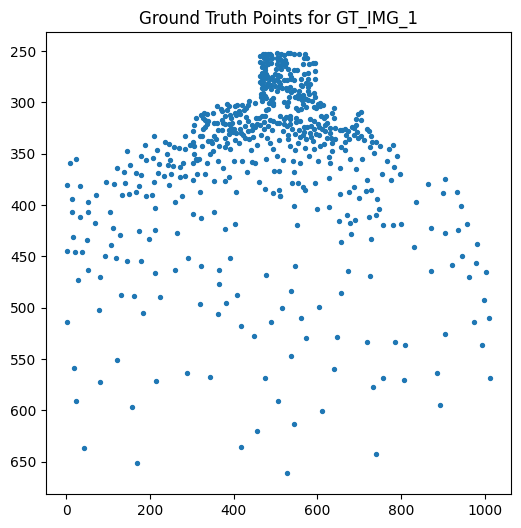

In [14]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np

data = loadmat(r"C:\Users\ACEPC\Desktop\DeepVision Crowd Monitoring\data\ShanghaiTech\part_A\train_data\ground-truth\GT_IMG_5.mat")

# access GT points
points = data['image_info'][0][0][0][0][0]

print("Number of points (people):", len(points))
print(points[:5])   # first 5 points

# visualize points
plt.figure(figsize=(6,6))
plt.scatter(points[:,0], points[:,1], s=8)
plt.title("Ground Truth Points for GT_IMG_1")
plt.gca().invert_yaxis()   # important (origin top-left)
plt.show()


Overlaying the .mat file points to images to verify the output.

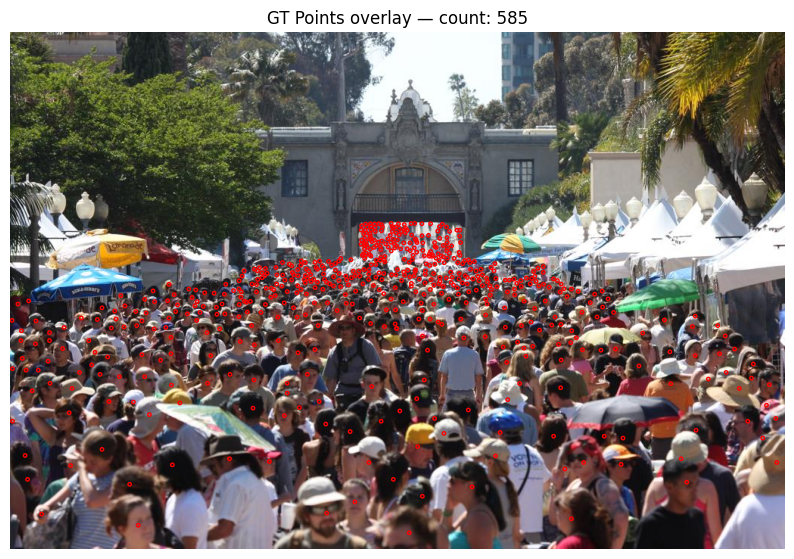

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

# paths — change if zarurat ho
mat_path = r"C:\Users\ACEPC\Desktop\DeepVision Crowd Monitoring\data\ShanghaiTech\part_A\train_data\ground-truth\GT_IMG_5.mat"
img_path = r"C:\Users\ACEPC\Desktop\DeepVision Crowd Monitoring\data\ShanghaiTech\part_A\train_data\images\IMG_5.jpg"

# load
data = loadmat(mat_path)
points = data['image_info'][0][0][0][0][0]   # Nx2 array (x,y)

# read image (cv2 -> BGR)
img = cv2.imread(img_path)
if img is None:
    raise FileNotFoundError(f"Image not found: {img_path}")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# plot overlay
plt.figure(figsize=(10,8))
plt.imshow(img_rgb)
# Matplotlib's image origin is top-left for imshow, so plot points directly.
plt.scatter(points[:,0], points[:,1], s=6, marker='o', facecolors='none', edgecolors='r')
plt.title(f"GT Points overlay — count: {len(points)}")
plt.axis('off')
plt.show()


Creating Guassian Density maps.

Sum of density (should approx people count): 582.0056


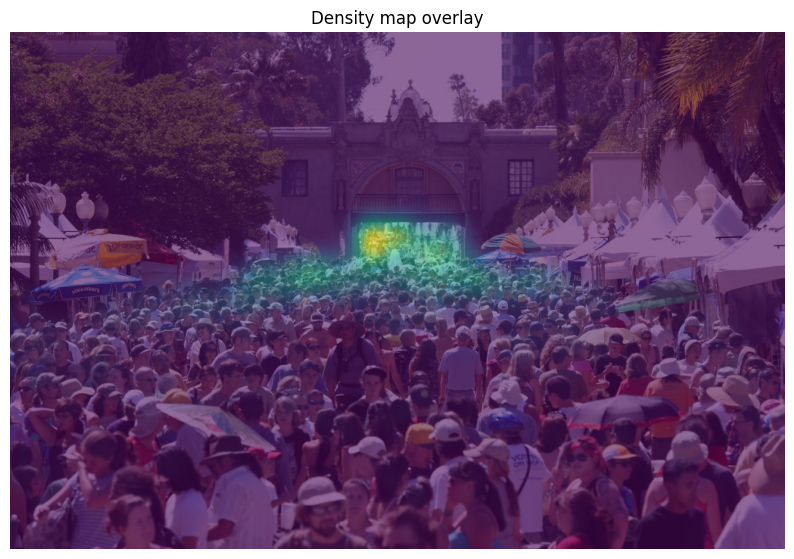

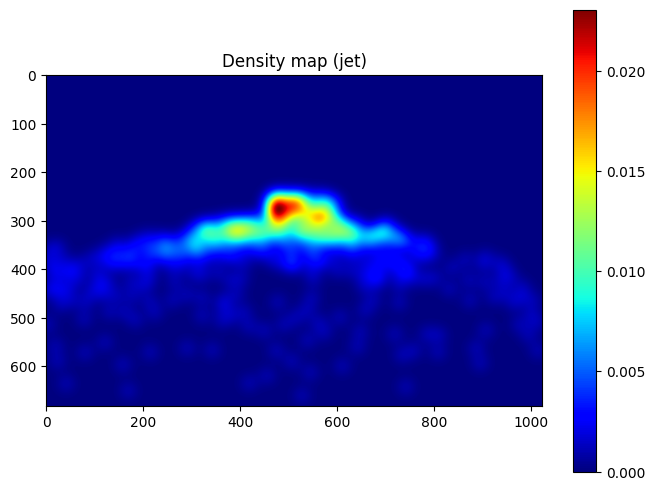

True

In [16]:
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import cv2

def generate_density_map(image_shape, points, sigma=15):
    """
    image_shape: (H, W) from the original image
    points: Nx2 array (x, y)
    sigma: gaussian sigma in pixels (tune as needed)
    returns: density map (H x W) float32
    """
    H, W = image_shape[:2]
    density = np.zeros((H, W), dtype=np.float32)

    # round the coordinates to nearest integer indices (clamp to image bounds)
    for p in points:
        x = min(W-1, max(0, int(round(p[0]))))
        y = min(H-1, max(0, int(round(p[1]))))
        density[y, x] += 1.0  # note [row=y, col=x]

    # smooth with gaussian
    density = gaussian_filter(density, sigma=sigma, mode='constant')
    return density

# use same img as above for shape
density_map = generate_density_map(img.shape, points, sigma=15)
print("Sum of density (should approx people count):", density_map.sum())

# visualize density map (heatmap)
plt.figure(figsize=(10,8))
plt.imshow(img_rgb)
plt.imshow(density_map, alpha=0.6)   # overlay semi-transparent
plt.title("Density map overlay")
plt.axis('off')
plt.show()

# separate density heatmap
plt.figure(figsize=(8,6))
plt.imshow(density_map, cmap='jet')
plt.title("Density map (jet)")
plt.colorbar()
plt.show()

# save outputs if needed
np.save("GT_IMG_1_density.npy", density_map)                # raw array
cv2.imwrite("GT_IMG_1_density_vis.png", (255*np.clip(density_map/density_map.max(),0,1)).astype(np.uint8))
